# Data Processing

In [20]:
import json
import os
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import os
import numpy as np
import neurokit2 as nk

In [22]:
import pandas as pd

def convert_to_dataframe(user_data):
    # Extract user details
    details = user_data["user_details"]
    name = details['name']
    
    # Create DataFrame for timestamp and feature signals
    df = pd.DataFrame({
        "timestamp": user_data["timestamp"],  # Assuming these timestamps are in milliseconds
        "ECG": user_data["ecg"],
        "GSR": user_data["gsr"],
        "PPG_red": user_data["ppg_red"],
        "PPG_ir": user_data["ppg_ir"],
        "PPG_green": user_data["ppg_green"]
    })
    
    # Convert timestamps from milliseconds to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    # Calculate the sampling frequency
    # Ensure timestamp is sorted or represents sequential data
    time_diffs = df['timestamp'].diff().dt.total_seconds().dropna()  # Calculate differences in seconds
    avg_sampling_interval = time_diffs.mean()  # Calculate average time difference in seconds
    sampling_frequency = 1 / avg_sampling_interval if avg_sampling_interval > 0 else None
    
    print(f"Sampling Freq: {sampling_frequency} Hz")
    
    # Append the calculated sampling frequency and user details as attributes
    df.attrs = {**details, "sampling_frequency": round(sampling_frequency)}
    
    return name, df

In [38]:
FileNames = ["Alysonn_2024-03-07_17-58-45", "Jared_2024-03-07_18-54-03","Thomas_2024-03-07_19-47-05"]

# Dictionary to hold DataFrames for each file
dataframes = {}

# Base path assumes files are one directory up from the current script's directory
base_path = os.path.join(os.getcwd(), '..')

# Loop through each file in FileNames
for file_name in FileNames:
    json_file_path = os.path.join(base_path, f"Data/{file_name}.json")  # Construct file path
    normalized_path = os.path.normpath(json_file_path)  # Normalize the path

    try:
        with open(normalized_path, 'r') as file:
            data = json.load(file)
        print(f"JSON data successfully loaded from {file_name}.")
        
        # Convert dictionary to pandas DataFrame
        name, df = convert_to_dataframe(data)
        
        # Store the DataFrame in the dictionary
        dataframes[name] = df

    except Exception as e:
        print(f"Failed to load JSON data from {file_name}: {e}")
        
# my_data = dataframes['LAURIE_ECG_ARM_PPG_INDEX']
my_data = dataframes['Jared']
SF = round(my_data.attrs['sampling_frequency']


JSON data successfully loaded from Alysonn_2024-03-07_17-58-45.
Sampling Freq: 79.60064353256722 Hz
JSON data successfully loaded from Jared_2024-03-07_18-54-03.
Sampling Freq: 79.40282604633514 Hz
JSON data successfully loaded from Thomas_2024-03-07_19-47-05.
Sampling Freq: 79.39215391008098 Hz


# ECG

Text(0.5, 1.0, 'Cleaned ECG')

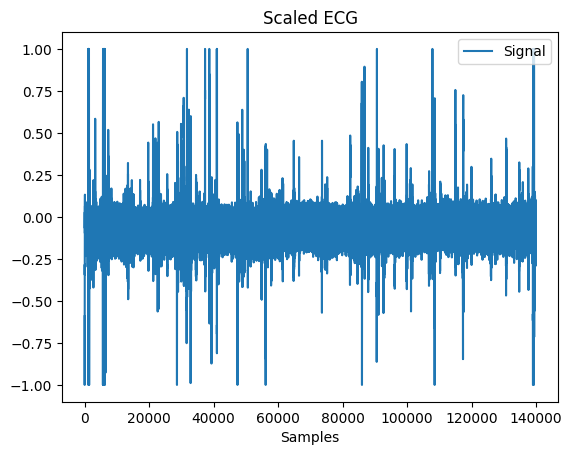

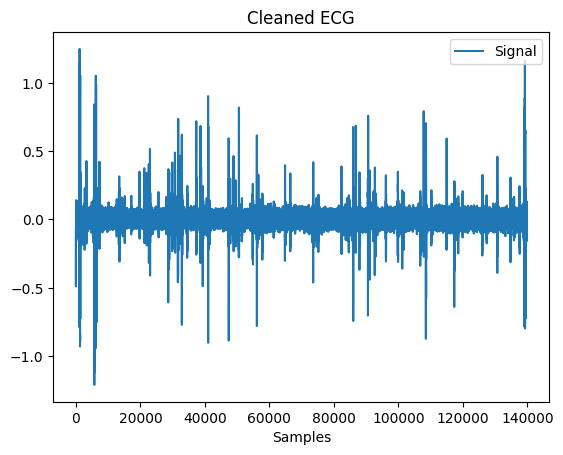

In [40]:
from sklearn.preprocessing import RobustScaler

# Calculate the mean and standard deviation
mean = my_data['ECG'].mean()
std_dev = my_data['ECG'].std()

remove_outlier = False
if remove_outlier:
    # Define your threshold for deviation from the mean
    threshold = 2

    # Filter out outliers
    outliers_mask = (my_data['ECG'] < mean - threshold * std_dev) | (my_data['ECG'] > mean + threshold * std_dev)

    outliers = my_data['ECG'][outliers_mask]

    filtered_ecg = my_data['ECG'][~outliers_mask]

    nk.signal_plot(my_data['ECG'])

    fig = plt.gcf()
    plt.title('Raw ECG')

    plt.figure()
    plt.scatter(my_data['timestamp'][outliers_mask], outliers, color = 'red')
    plt.scatter(my_data['timestamp'][~outliers_mask], filtered_ecg, color = 'blue')
    plt.title('Outlier Removal')
    # Reshape data for the scaler
    data_reshaped = filtered_ecg.values.reshape(-1, 1)
    
else:
    data_reshaped = my_data['ECG'].values.reshape(-1, 1)
    
# Initialize the RobustScaler
robust_scaler = RobustScaler()

# Fit and transform the data with RobustScaler
data_robust_scaled = robust_scaler.fit_transform(data_reshaped)

# Manually scale to [-1, 1] based on the robustly scaled data
data_scaled_to_range = np.interp(data_robust_scaled, (data_robust_scaled.min(), data_robust_scaled.max()), (-1, 1))

# Convert back to a pandas series, if needed
ecg_data = pd.Series(data_scaled_to_range.flatten())

nk.signal_plot(ecg_data)

fig = plt.gcf()
plt.title('Scaled ECG')

# Process ecg
ecg_signals, info = nk.ecg_process(ecg_data, sampling_rate = SF, method = 'neurokit')
nk.signal_plot(ecg_signals['ECG_Clean'])
fig = plt.gcf()
plt.title('Cleaned ECG') 



In [36]:
print(SF)

79.60064353256722


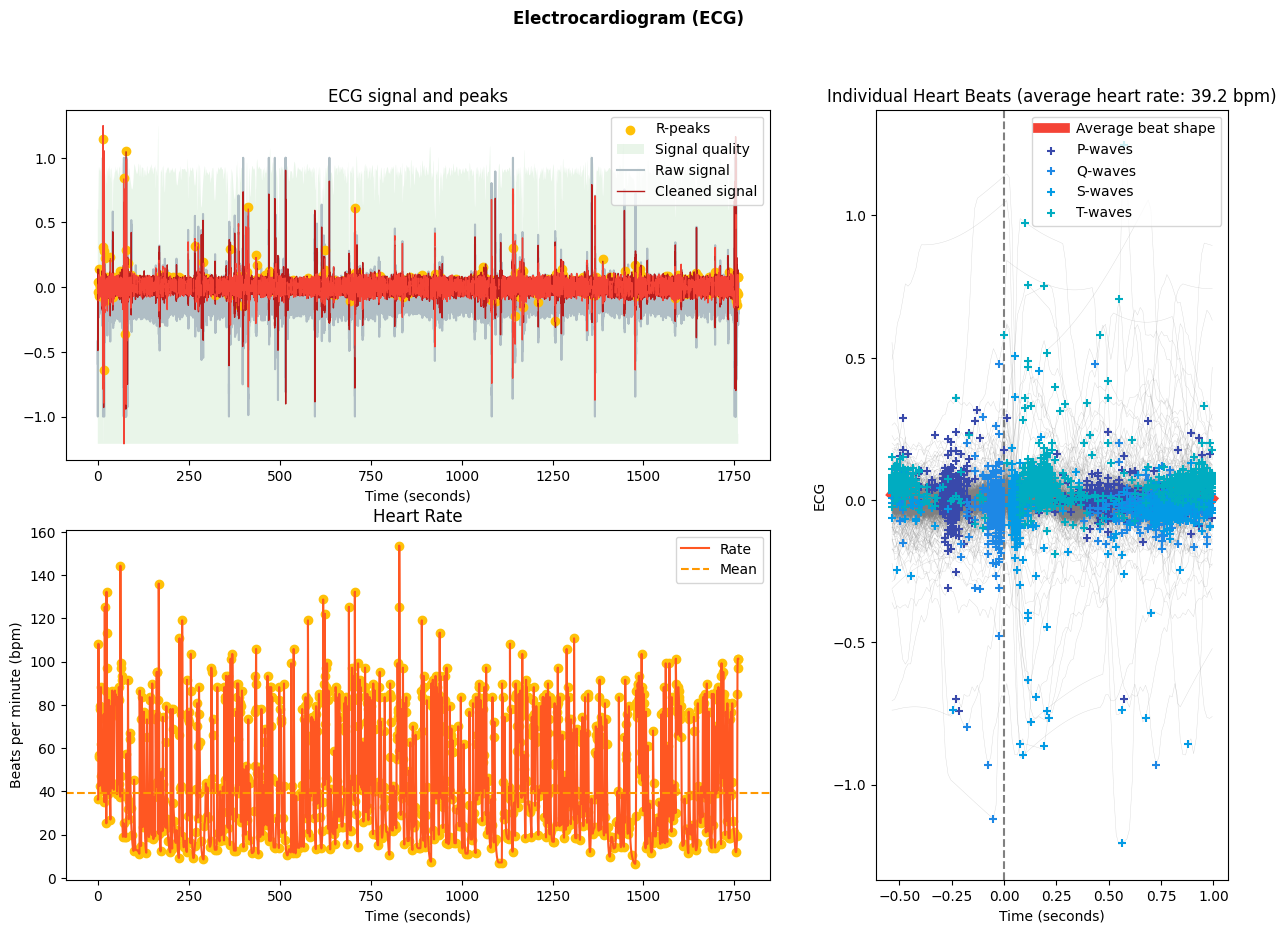

In [42]:
nk.ecg_plot(ecg_signals, info)
fig = plt.gcf()
fig.set_size_inches(15, 10, forward=True)
# fig.savefig("myfig.png")

These features include the RMSSD (square root of the mean of the sum of successive differences between adjacent RR intervals), MeanNN (mean of RR intervals) 

    HRV_MeanNN     HRV_SDNN  HRV_SDANN1   HRV_SDNNI1  HRV_SDANN2   HRV_SDNNI2  \
0  1655.875164  1256.742022  390.089153  1229.363909  233.840853  1247.545595   

   HRV_SDANN5   HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_SampEn  \
0   141.62884  1251.927308  1566.94303  1567.68198  ...    1.139688   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    7.355946       1.2441  0.903571   1.318772    1.275722  1.059851   

    HRV_HFD   HRV_KFD   HRV_LZC  
0  1.959467  3.304071  0.899241  

[1 rows x 91 columns]


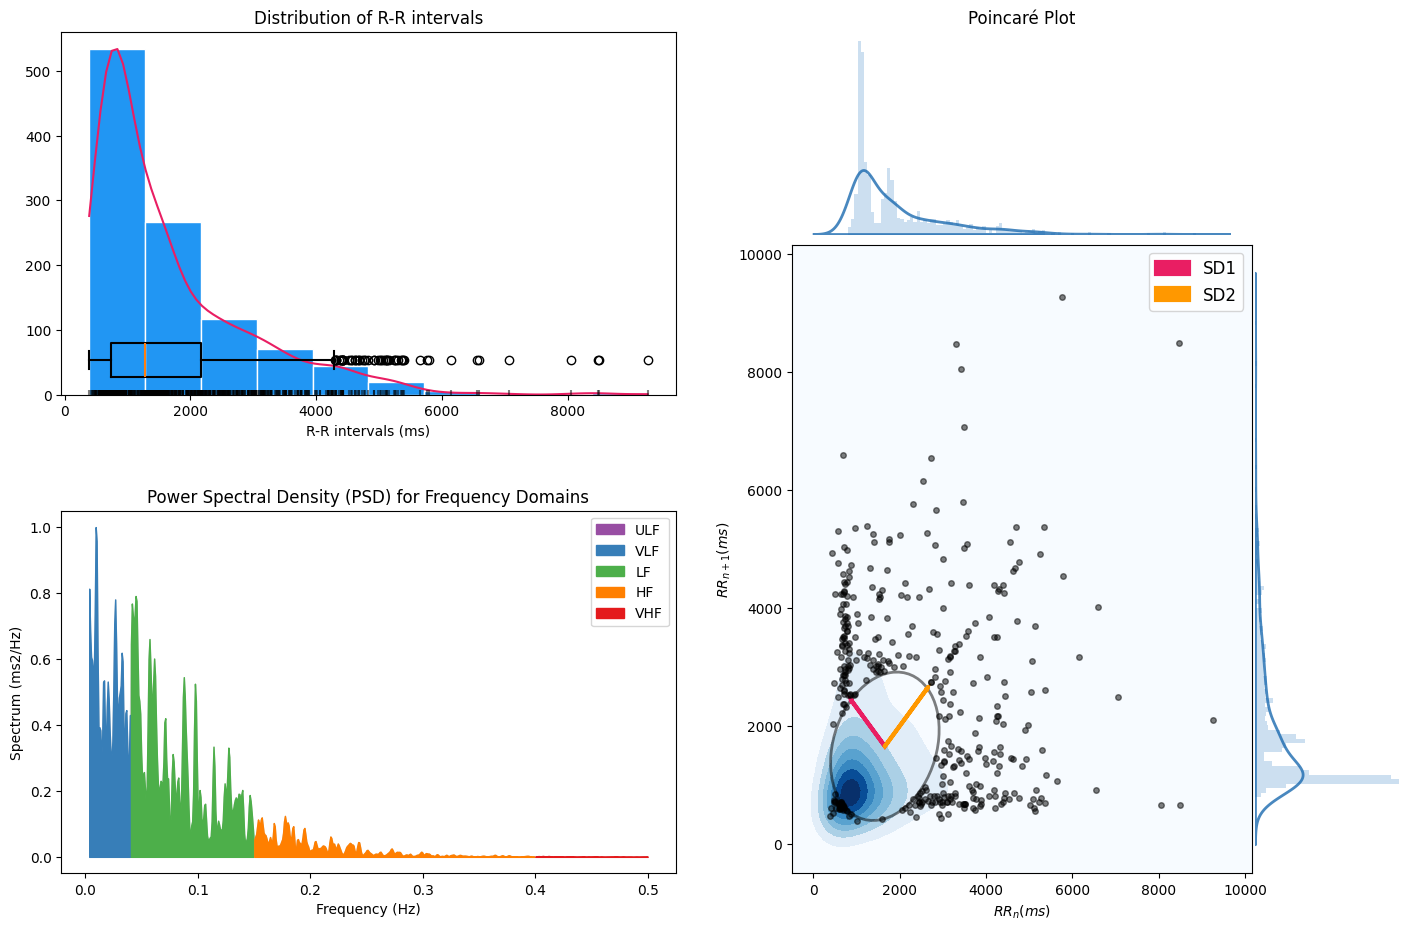

In [43]:
hrv_indices = nk.hrv(ecg_signals, sampling_rate=SF, show=True)
hrv_indices
print(hrv_indices)
fig = plt.gcf()
fig.set_size_inches(15, 10, forward=True)

### Interval ECG

MeanNN: The mean of the RR intervals.

SDNN: The standard deviation of the RR intervals.

SDANN1, SDANN2, SDANN5: The standard deviation of average RR intervals extracted from n-minute segments of time series data (1, 2 and 5 by default). Note that these indices require a minimal duration of signal to be computed (3, 6 and 15 minutes respectively) and will be silently skipped if the data provided is too short.

SDNNI1, SDNNI2, SDNNI5: The mean of the standard deviations of RR intervals extracted from n-minute segments of time series data (1, 2 and 5 by default). Note that these indices require a minimal duration of signal to be computed (3, 6 and 15 minutes respectively) and will be silently skipped if the data provided is too short.

RMSSD: The square root of the mean of the squared successive differences between adjacent RR intervals. It is equivalent (although on another scale) to SD1, and therefore it is redundant to report correlations with both (Ciccone, 2017).

SDSD: The standard deviation of the successive differences between RR intervals.

CVNN: The standard deviation of the RR intervals (SDNN) divided by the mean of the RR intervals (MeanNN).

CVSD: The root mean square of successive differences (RMSSD) divided by the mean of the RR intervals (MeanNN).

MedianNN: The median of the RR intervals.

MadNN: The median absolute deviation of the RR intervals.

MCVNN: The median absolute deviation of the RR intervals (MadNN) divided by the median of the RR intervals (MedianNN).

IQRNN: The interquartile range (IQR) of the RR intervals.

SDRMSSD: SDNN / RMSSD, a time-domain equivalent for the low Frequency-to-High Frequency (LF/HF) Ratio (Sollers et al., 2007).

Prc20NN: The 20th percentile of the RR intervals (Han, 2017; Hovsepian, 2015).

Prc80NN: The 80th percentile of the RR intervals (Han, 2017; Hovsepian, 2015).

pNN50: The proportion of RR intervals greater than 50ms, out of the total number of RR intervals.

pNN20: The proportion of RR intervals greater than 20ms, out of the total number of RR intervals.

MinNN: The minimum of the RR intervals (Parent, 2019; Subramaniam, 2022).

MaxNN: The maximum of the RR intervals (Parent, 2019; Subramaniam, 2022).

TINN: A geometrical parameter of the HRV, or more specifically, the baseline width of the RR intervals distribution obtained by triangular interpolation, where the error of least squares determines the triangle. It is an approximation of the RR interval distribution.

HTI: The HRV triangular index, measuring the total number of RR intervals divided by the height of the RR intervals histogram.

In [31]:
print(ecg_signals)

         ECG_Raw  ECG_Clean   ECG_Rate  ECG_Quality  ECG_R_Peaks  ECG_P_Peaks  \
0      -0.993333  -0.013490  23.263056     0.844395            0            0   
1      -0.772424   0.190737  23.263056     0.844395            0            0   
2      -0.518182   0.301953  23.263056     0.844395            0            0   
3      -0.702424   0.277953  23.263056     0.844395            0            0   
4      -0.583636   0.295265  23.263056     0.844395            0            0   
...          ...        ...        ...          ...          ...          ...   
137345  0.448788   0.322103  26.386954     0.000000            0            0   
137346  0.264242   0.275093  26.386954     0.000000            0            0   
137347  0.309697   0.261759  26.386954     0.000000            0            0   
137348  0.367273   0.243158  26.386954     0.000000            0            0   
137349  0.145455   0.088691  26.386954     0.000000            0            0   

        ECG_P_Onsets  ECG_P

In [30]:
events = nk.events_create(event_onsets = [5000, 20000],
                          event_durations = [1000, 000], 
                          event_labels = ['Video 1', 'Video 2'],
                          event_conditions =['Happy', 'Sad']
                        ) 

# Creating epochs
epochs = nk.epochs_create(ecg_signals, 
                            events = events, 
                            sampling_rate = SF, 
                            event_labels = ['Video 1', 'Video 2'],
                            event_conditions = ['Happy', 'Sad'],  
                            baseline_correction=False)

ECG_Features = nk.ecg_intervalrelated(epochs)



c:\Users\lauri\.virtualenvs\AML-dynaMix-AryBn7L8\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Users\lauri\.virtualenvs\AML-dynaMix-AryBn7L8\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
c:\Users\lauri\.virtualenvs\AML-dynaMix-AryBn7L8\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Users\lauri\.virtualenvs\AML-dynaMix

In [9]:
print(ECG_Features)

           Label  ECG_Rate_Mean              HRV_MeanNN  \
Video 1  Video 1      75.058985  [[20.797202797202797]]   
Video 2  Video 2      73.802367  [[21.156028368794328]]   

                       HRV_SDNN HRV_SDANN1 HRV_SDNNI1 HRV_SDANN2 HRV_SDNNI2  \
Video 1  [[2.0333814221339397]]    [[nan]]    [[nan]]    [[nan]]    [[nan]]   
Video 2  [[2.0010129147268763]]    [[nan]]    [[nan]]    [[nan]]    [[nan]]   

        HRV_SDANN5 HRV_SDNNI5  ...              HRV_SampEn  \
Video 1    [[nan]]    [[nan]]  ...  [[1.3835732710055302]]   
Video 2    [[nan]]    [[nan]]  ...  [[1.3646328643387111]]   

                     HRV_ShanEn             HRV_FuzzyEn  \
Video 1   [[2.958128764882213]]  [[1.1155716675827796]]   
Video 2  [[2.7225238122586632]]  [[1.0883450380939586]]   

                       HRV_MSEn               HRV_CMSEn  \
Video 1   [[1.238414658153364]]  [[1.3059180076923318]]   
Video 2  [[1.1987550940563816]]  [[1.2490025671094485]]   

                     HRV_RCMSEn          

### ECG Derived RSP Features

Returns: 

"RSP_Rate_Mean": the mean respiratory rate.

"RSP_Amplitude_Mean": the mean respiratory amplitude.

"RSP_RRV": the different respiratory rate variability metrices. See below.

"RSP_Phase_Duration_Inspiration": the average inspiratory duration.

"RSP_Phase_Duration_Expiration": the average expiratory duration.

"RSP_Phase_Duration_Ratio ": the inspiratory-to-expiratory time ratio (I/E).

#### RSP_RRV

"RRV_SDBB": the standard deviation of the breath-to-breath intervals.

"RRV_RMSSD": the root mean square of successive differences of the breath-to-breath intervals.

"RRV_SDSD": the standard deviation of the successive differences between adjacent breath-to-breath intervals.

"RRV_BBx": the number of successive interval differences that are greater than x seconds.

"RRV-pBBx": the proportion of breath-to-breath intervals that are greater than x seconds, out of the total number of intervals.

"RRV_VLF": spectral power density pertaining to very low frequency band (i.e., 0 to . 04 Hz) by default.

"RRV_LF": spectral power density pertaining to low frequency band (i.e., .04 to .15 Hz) by default.

"RRV_HF": spectral power density pertaining to high frequency band (i.e., .15 to .4 Hz) by default.

"RRV_LFHF": the ratio of low frequency power to high frequency power.

"RRV_LFn": the normalized low frequency, obtained by dividing the low frequency power by the total power.

"RRV_HFn": the normalized high frequency, obtained by dividing the low frequency power by total power.

"RRV_SD1": SD1 is a measure of the spread of breath-to-breath intervals on the Poincaré plot perpendicular to the line of identity. It is an index of short-term variability.

"RRV_SD2": SD2 is a measure of the spread of breath-to-breath intervals on the Poincaré plot along the line of identity. It is an index of long-term variability.

"RRV_SD2SD1": the ratio between short and long term fluctuations of the breath-to-breath intervals (SD2 divided by SD1).

"RRV_ApEn": the approximate entropy of RRV, calculated by entropy_approximate().

"RRV_SampEn": the sample entropy of RRV, calculated by entropy_sample().

"RRV_DFA_alpha1": the “short-term” fluctuation value generated from Detrended Fluctuation Analysis i.e. the root mean square deviation from the fitted trend of the breath-to-breath intervals. Will only be computed if mora than 160 breath cycles in the signal.

"RRV_DFA_alpha2": the long-term fluctuation value. Will only be computed if mora than 640 breath cycles in the signal.

           Label  RSP_Rate_Mean    RRV_RMSSD   RRV_MeanBB     RRV_SDBB  \
Video 1  Video 1      10.036267  2564.136618  5916.289593  2716.009519   
Video 2  Video 2      10.535793  3962.762237  5670.040486  3102.545979   

            RRV_SDSD  RRV_CVBB  RRV_CVSD  RRV_MedianBB    RRV_MadBB  ...  \
Video 1  2563.925074  0.459073  0.433403   5423.076923  1539.623077  ...   
Video 2  4066.990852  0.547182  0.698895   5269.230769  2509.015385  ...   

          RAV_Mean     RAV_SD  RAV_RMSSD  RAV_CVSD   RSP_RVT  \
Video 1  24.287490  14.938378   21.62985  0.890576  3.803973   
Video 2  22.327855  13.139422   18.11154  0.811163  3.738992   

         RSP_Symmetry_PeakTrough  RSP_Symmetry_RiseDecay  \
Video 1                 0.547411                0.494602   
Video 2                 0.532807                0.508791   

         RSP_Phase_Duration_Inspiration  RSP_Phase_Duration_Expiration  \
Video 1                        0.116985                       0.109011   
Video 2                   

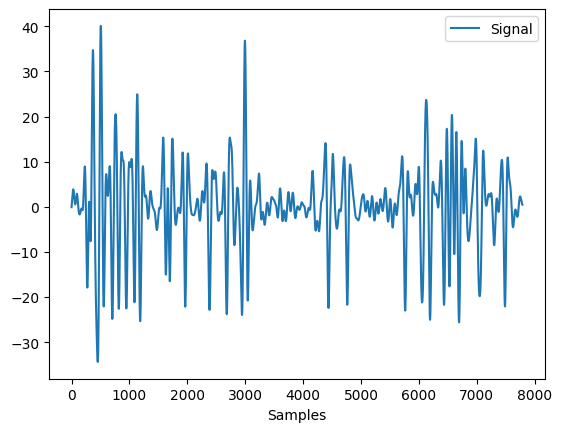

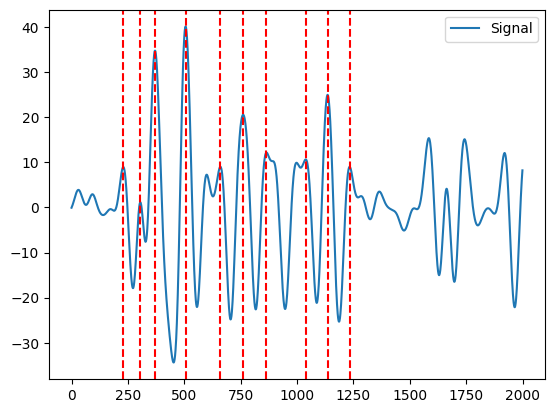

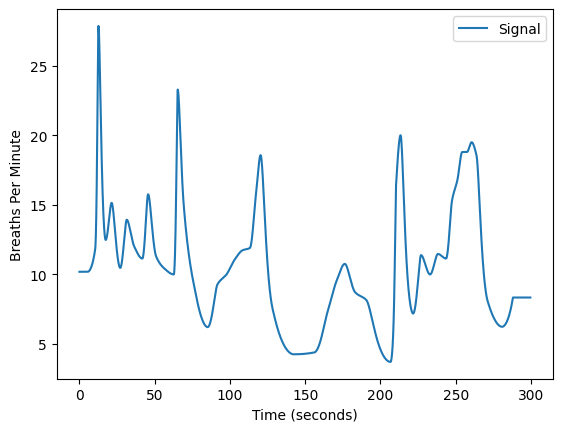

In [10]:
# # Extract peaks
rpeaks, info = nk.ecg_peaks(ecg_signals, sampling_rate=SF)

# Compute rate
ecg_rate = nk.ecg_rate(rpeaks, sampling_rate=SF, desired_length=len(my_data["ECG"]))

edr = nk.ecg_rsp(ecg_rate, sampling_rate=SF)

rsp_data, rsp_info = nk.rsp_process(edr, 
            sampling_rate=SF)

# Visual comparison
nk.signal_plot(rsp_data['RSP_Clean'])


candidate_peaks = nk.events_plot(rsp_info['RSP_Peaks'][0:10], rsp_data['RSP_Clean'][0:2000])


# Visualize
nk.signal_plot(rsp_data['RSP_Rate'], sampling_rate=SF)

plt.ylabel('Breaths Per Minute')



events = nk.events_create(event_onsets = [1000, 4000],
                          event_durations = [3000, 3000], 
                          event_labels = ['Video 1', 'Video 2'],
                          event_conditions =['Happy', 'Sad']
                        ) 

# Creating epochs
epochs = nk.epochs_create(rsp_data, 
                            events = events, 
                            sampling_rate = SF, 
                            event_labels = ['Video 1', 'Video 2'],
                            event_conditions = ['Happy', 'Sad'],  
                            baseline_correction=False)

RSP_Features = nk.rsp_intervalrelated(epochs, sampling_rate=SF)

print(RSP_Features)


# PPG

# GSR

### ECG Peak Testing

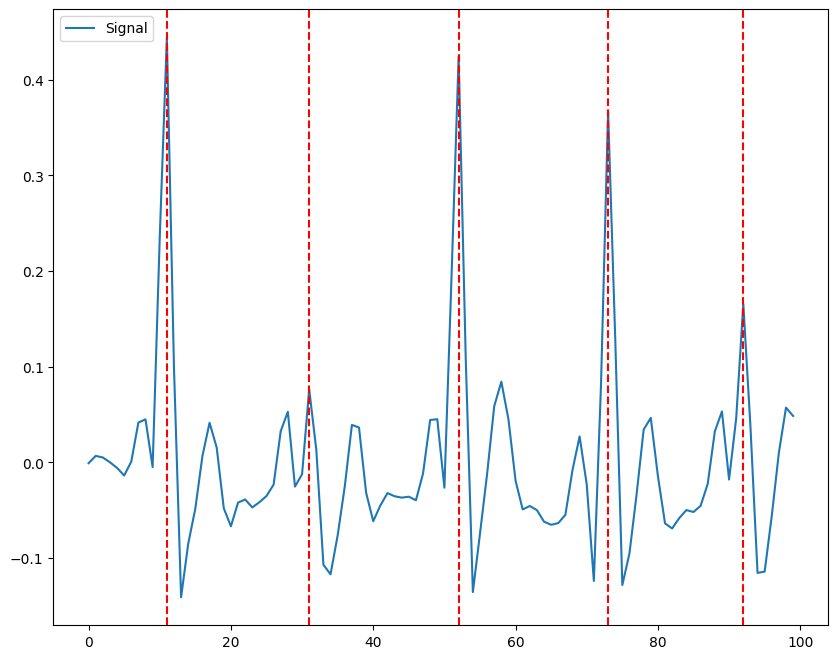

In [11]:
# Extract R-peaks locations
_, rpeaks = nk.ecg_peaks(ecg_signals, sampling_rate=SF)
# Zooming into the first 5 R-peaks
plot = nk.events_plot(rpeaks['ECG_R_Peaks'][:5], ecg_signals['ECG_Clean'][:100])
fig = plt.gcf()
fig.set_size_inches(10, 8, forward=True)


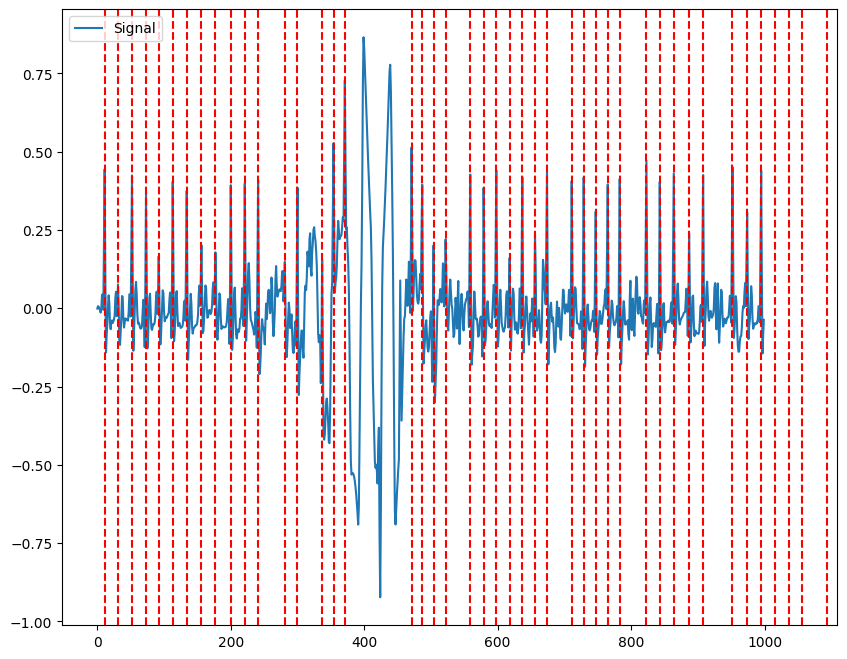

In [12]:
plot = nk.events_plot(rpeaks['ECG_R_Peaks'][0:45], ecg_signals['ECG_Clean'][0:1000])
fig = plt.gcf()
fig.set_size_inches(10, 8, forward=True)

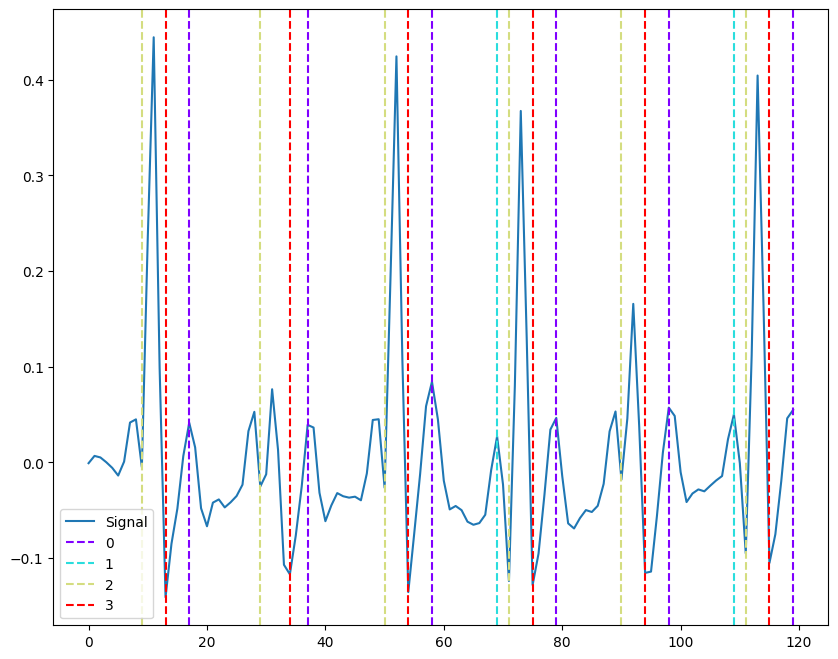

In [13]:
_, waves_peak = nk.ecg_delineate(ecg_signals, rpeaks, sampling_rate=1000, method="peak")

# Zooming into the first 3 R-peaks, with focus on T_peaks, P-peaks, Q-peaks and S-peaks
plot = nk.events_plot([waves_peak['ECG_T_Peaks'][:6], 
                       waves_peak['ECG_P_Peaks'][:6],
                       waves_peak['ECG_Q_Peaks'][:6],
                       waves_peak['ECG_S_Peaks'][:6]], ecg_signals['ECG_Clean'][0:120])

fig = plt.gcf()
fig.set_size_inches(10, 8, forward=True)

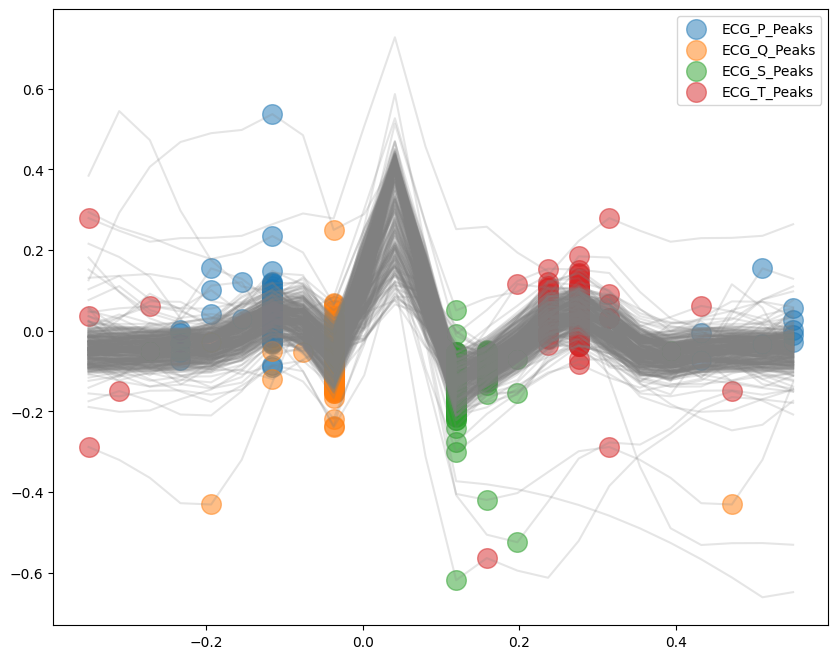

In [14]:
# Delineate the ECG signal and visualizing all peaks of ECG complexes
_, waves_peak = nk.ecg_delineate(ecg_signals['ECG_Clean'], 
                                 rpeaks, 
                                 sampling_rate=SF, 
                                 method="peak", 
                                 show=True, 
                                 show_type='peaks')
fig = plt.gcf()
fig.set_size_inches(10, 8, forward=True)

# Continuous Wavelet Method (CWT)

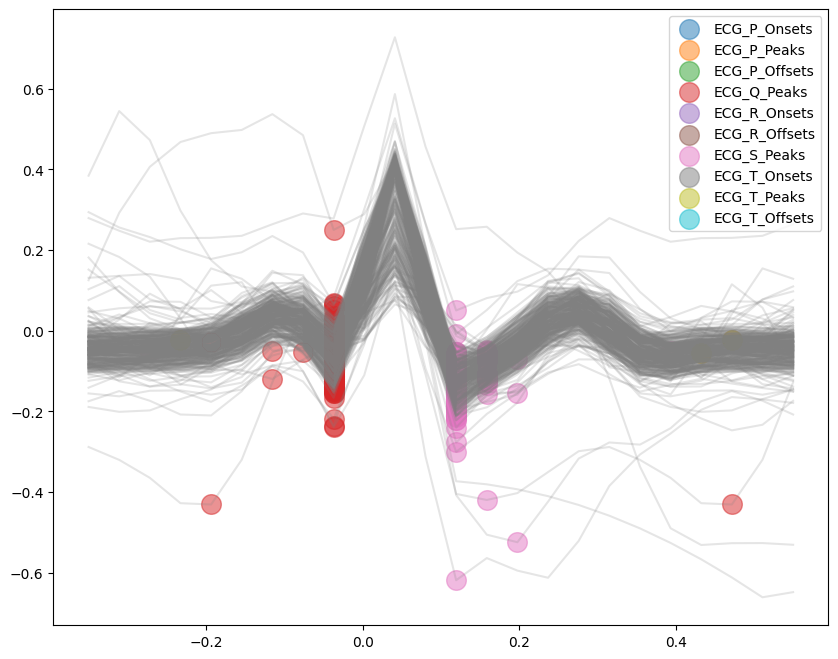

In [15]:
# Delineate the ECG signal
signal_cwt, waves_cwt = nk.ecg_delineate(ecg_signals['ECG_Clean'], 
                                         rpeaks, 
                                         sampling_rate=SF, 
                                         method="cwt", 
                                         show=True, 
                                         show_type='all')

fig = plt.gcf()
fig.set_size_inches(10, 8, forward=True)

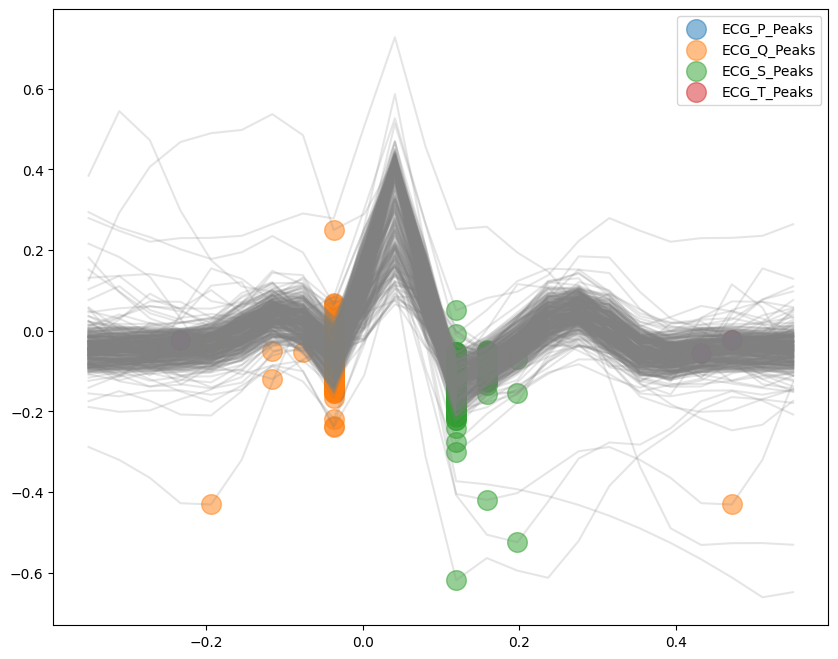

In [16]:
# Visualize P-peaks and T-peaks
signal_cwt, waves_cwt = nk.ecg_delineate(ecg_signals, 
                                         rpeaks, 
                                         sampling_rate=SF, 
                                         method="cwt", 
                                         show=True, 
                                         show_type='peaks')

fig = plt.gcf()
fig.set_size_inches(10, 8, forward=True)

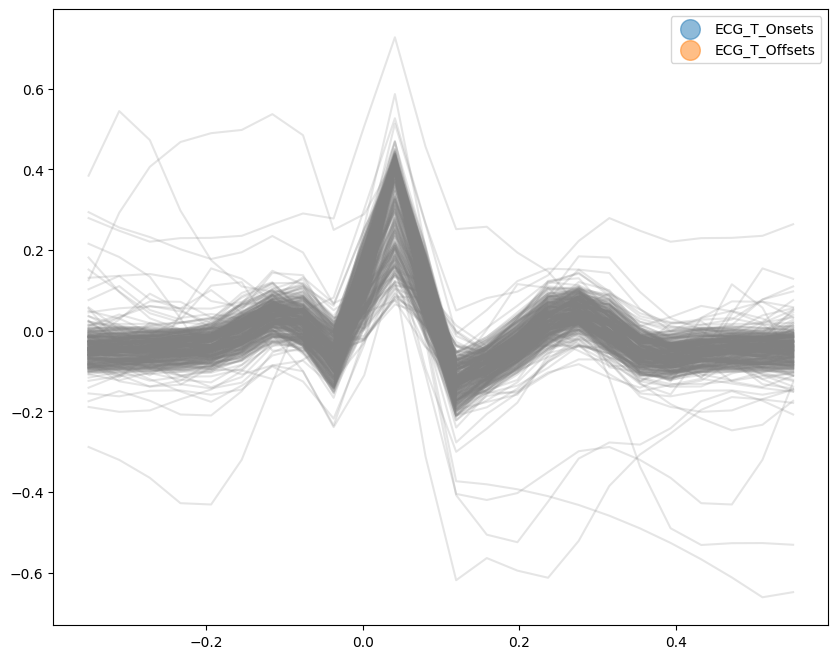

In [17]:
# Visualize T-waves boundaries
signal_cwt, waves_cwt = nk.ecg_delineate(ecg_signals, 
                                         rpeaks, 
                                         sampling_rate=SF, 
                                         method="cwt", 
                                         show=True, 
                                         show_type='bounds_T')

fig = plt.gcf()
fig.set_size_inches(10, 8, forward=True)

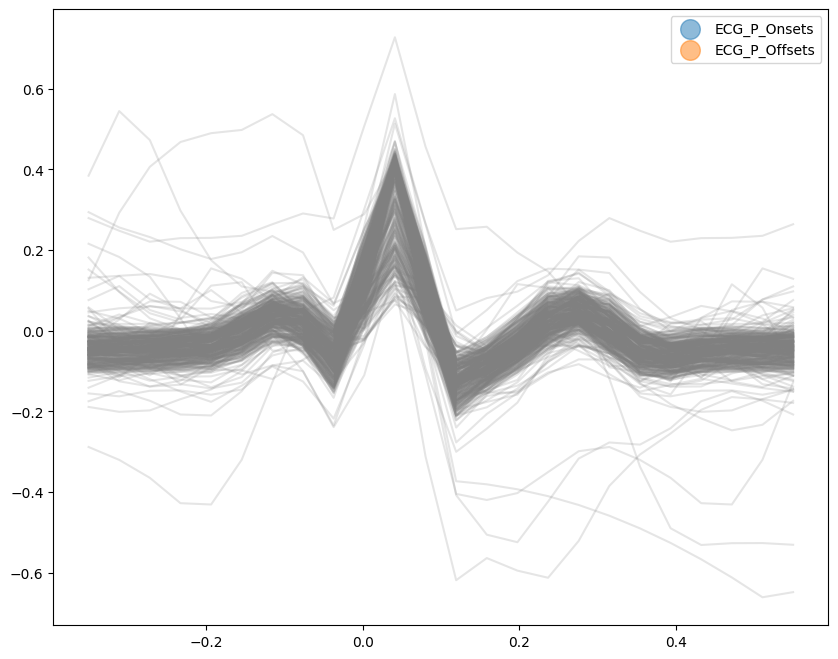

In [18]:
# Visualize P-waves boundaries
signal_cwt, waves_cwt = nk.ecg_delineate(ecg_signals, 
                                         rpeaks, 
                                         sampling_rate=SF, 
                                         method="cwt", 
                                         show=True, 
                                         show_type='bounds_P')

fig = plt.gcf()
fig.set_size_inches(10, 8, forward=True)

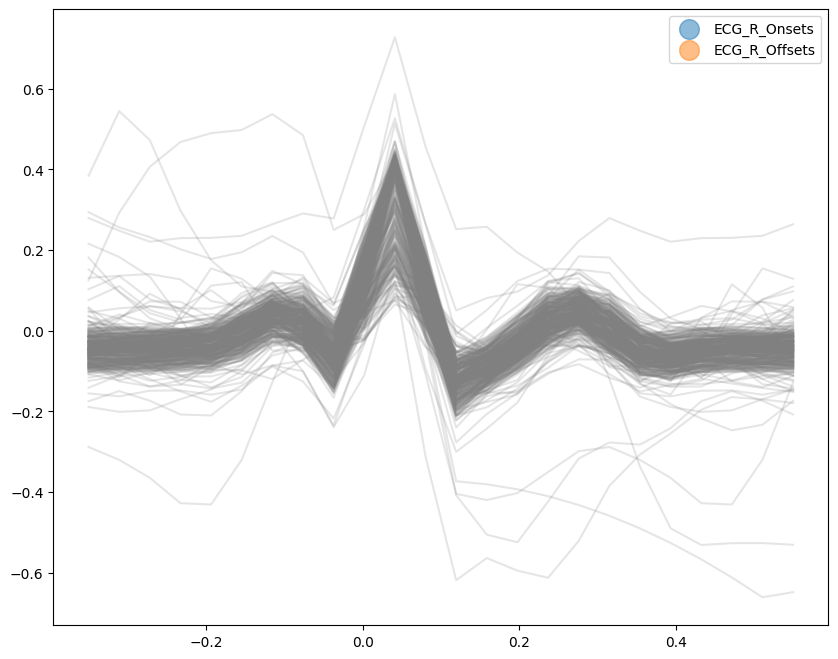

In [19]:
# Visualize R-waves boundaries
signal_cwt, waves_cwt = nk.ecg_delineate(ecg_signals, 
                                         rpeaks, 
                                         sampling_rate=SF, 
                                         method="cwt", 
                                         show=True, 
                                         show_type='bounds_R')
fig = plt.gcf()
fig.set_size_inches(10, 8, forward=True)

# DWT Method

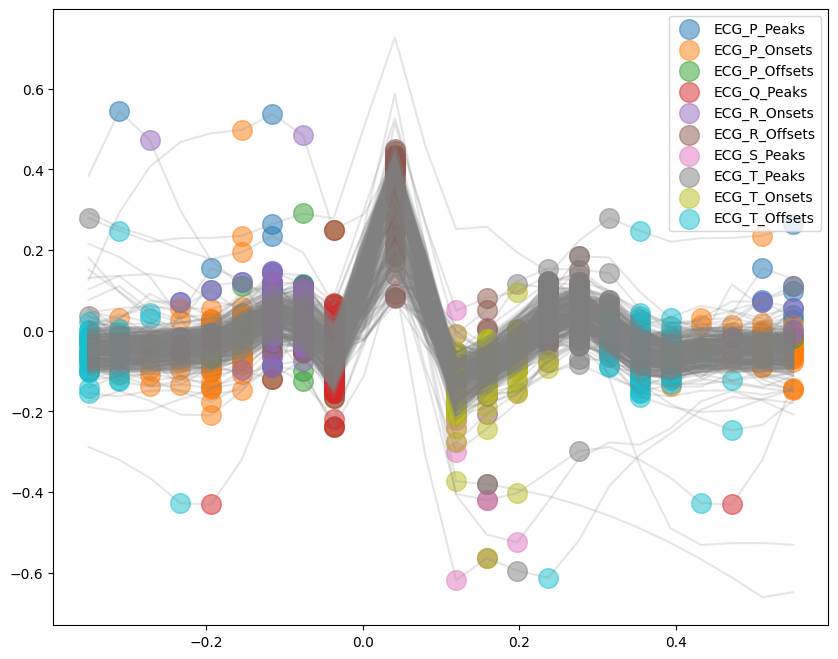

In [20]:
# Delineate the ECG signal
signal_dwt, waves_dwt = nk.ecg_delineate(ecg_signals, 
                                         rpeaks, 
                                         sampling_rate=SF, 
                                         method="dwt", 
                                         show=True, 
                                         show_type='all')

fig = plt.gcf()
fig.set_size_inches(10, 8, forward=True)

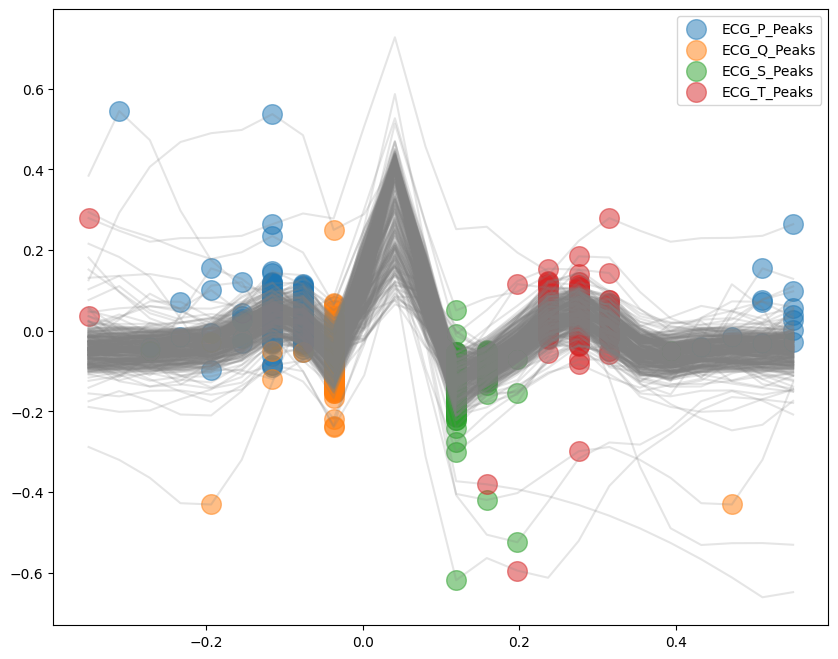

In [21]:
# Visualize P-peaks and T-peaks
signal_dwt, waves_dwt = nk.ecg_delineate(ecg_signals, 
                                         rpeaks, 
                                         sampling_rate=SF, 
                                         method="dwt", 
                                         show=True, 
                                         show_type='peaks')
fig = plt.gcf()
fig.set_size_inches(10, 8, forward=True)

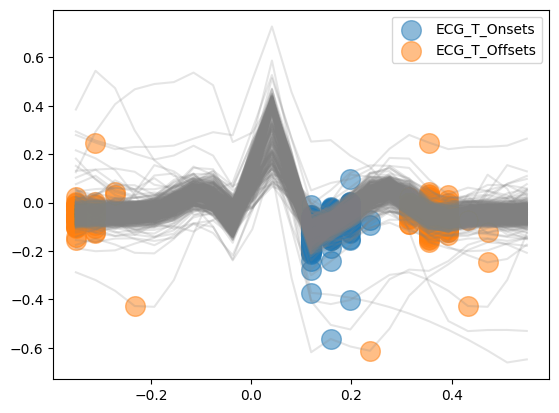

In [22]:
# visualize T-wave boundaries
signal_dwt, waves_dwt = nk.ecg_delineate(ecg_signals, 
                                         rpeaks, 
                                         sampling_rate=SF, 
                                         method="dwt", 
                                         show=True, 
                                         show_type='bounds_T')

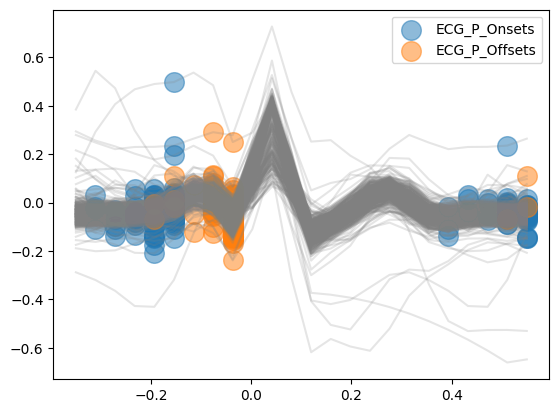

In [23]:
# Visualize P-wave boundaries
signal_dwt, waves_dwt = nk.ecg_delineate(ecg_signals, 
                                         rpeaks, 
                                         sampling_rate=SF, 
                                         method="dwt", 
                                         show=True, 
                                         show_type='bounds_P')

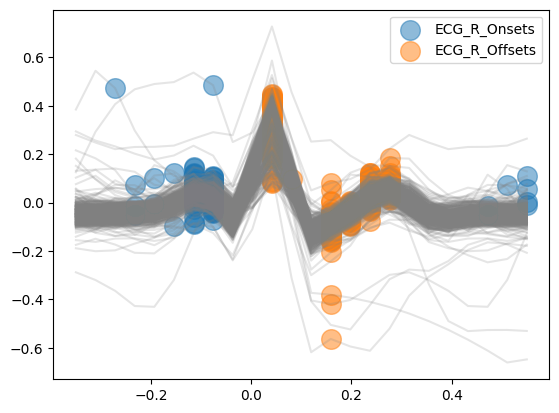

In [24]:
# Visualize R-wave boundaries
signal_dwt, waves_dwt = nk.ecg_delineate(ecg_signals, 
                                         rpeaks, 
                                         sampling_rate=SF, 
                                         method="dwt", 
                                         show=True, 
                                         show_type='bounds_R')

### Respiration ECG

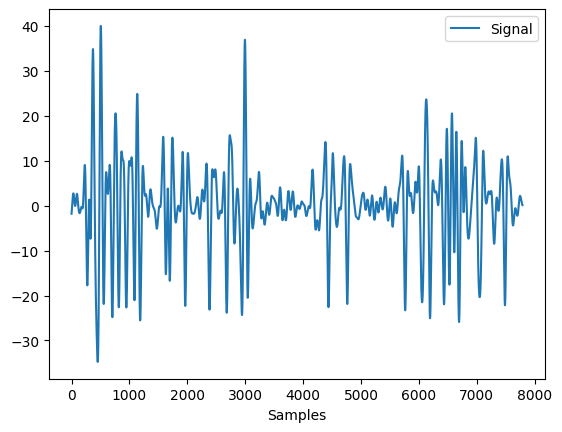

In [25]:
# Extract peaks
rpeaks, info = nk.ecg_peaks(ecg_signals, sampling_rate=SF)

# Compute rate
ecg_rate = nk.ecg_rate(rpeaks, sampling_rate=SF, desired_length=len(my_data["ECG"]))

edr = nk.ecg_rsp(ecg_rate, sampling_rate=SF)

# Visual comparison
nk.signal_plot(edr)

print()




,RRV_RMSSD,RRV_MeanBB,RRV_SDBB,RRV_SDSD,RRV_CVBB,RRV_CVSD,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,RRV_VLF,RRV_LF,RRV_HF,RRV_LFHF,RRV_LFn,RRV_HFn,RRV_SD1,RRV_SD2,RRV_SD2SD1,RRV_ApEn,RRV_SampEn
0,3357.254872,6013.91162,2952.81068,3394.045762,0.490997,0.558248,5384.615385,2280.923077,0.4236,0.005411,0.000762,0.000023,33.617252,0.122969,0.003658,2399.952774,3417.368653,1.423932,0.450641,1.335001


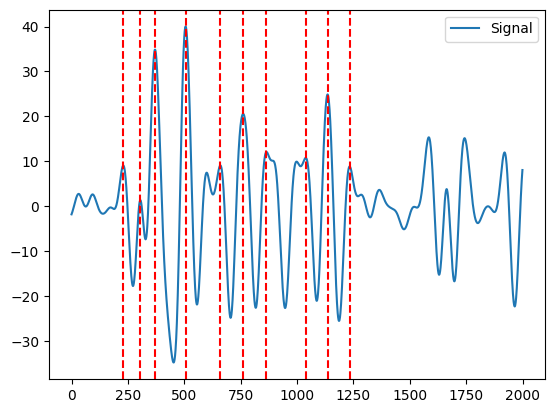

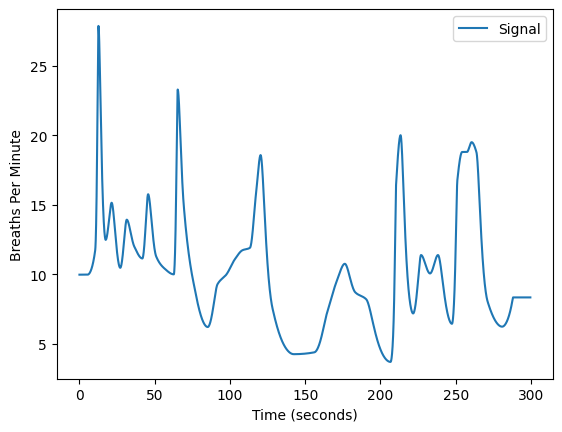

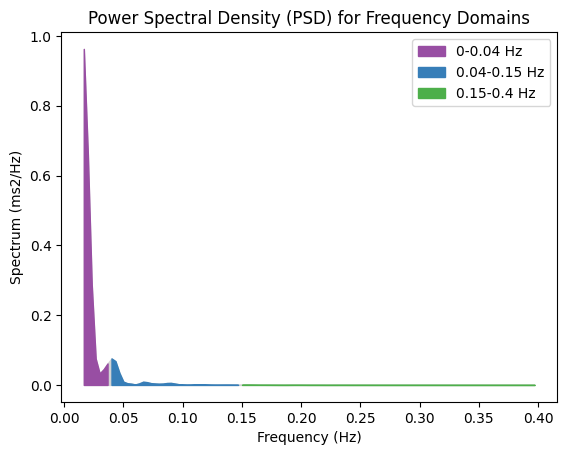

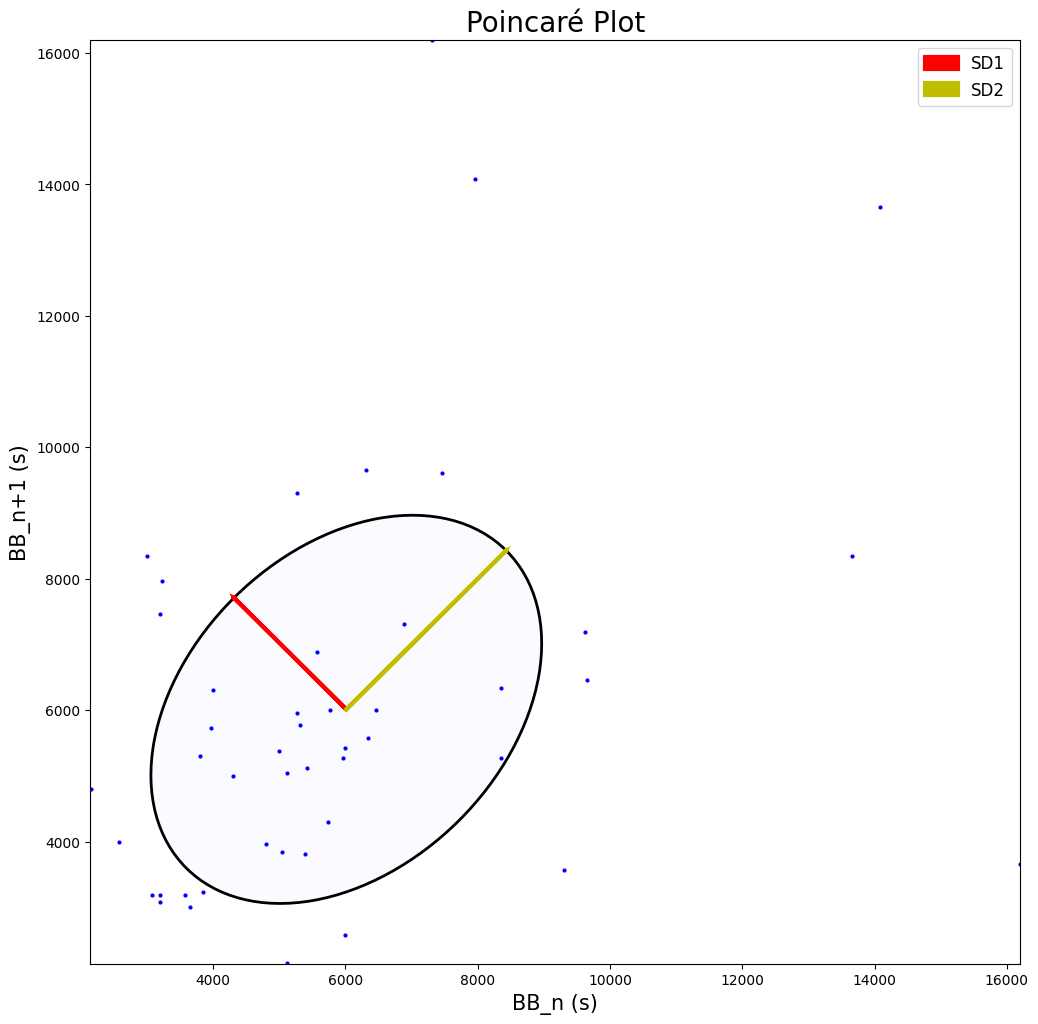

In [26]:
# Extract peaks
df, peaks_dict = nk.rsp_peaks(edr)

info = nk.rsp_fixpeaks(peaks_dict)

formatted = nk.signal_formatpeaks(info, desired_length=len(edr),peak_indices=info["RSP_Peaks"])


candidate_peaks = nk.events_plot(peaks_dict['RSP_Peaks'][0:10], edr[0:2000])

# Extract rate
rsp_rate = nk.rsp_rate(edr, peaks_dict, sampling_rate=SF)

# Visualize
nk.signal_plot(rsp_rate, sampling_rate=SF)

plt.ylabel('Breaths Per Minute')

rrv = nk.rsp_rrv(rsp_rate, info, sampling_rate=SF, show=True)

rrv

# PPG

TypeError: list indices must be integers or slices, not str

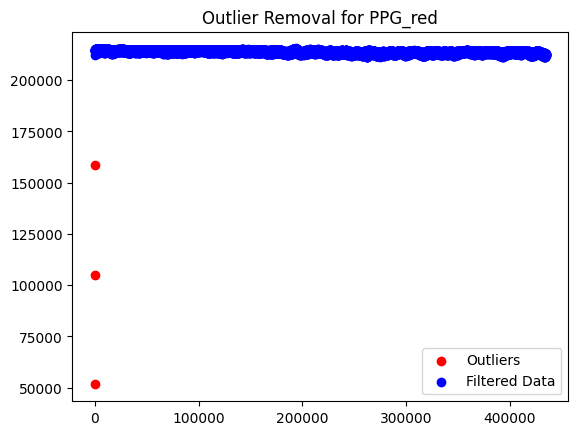

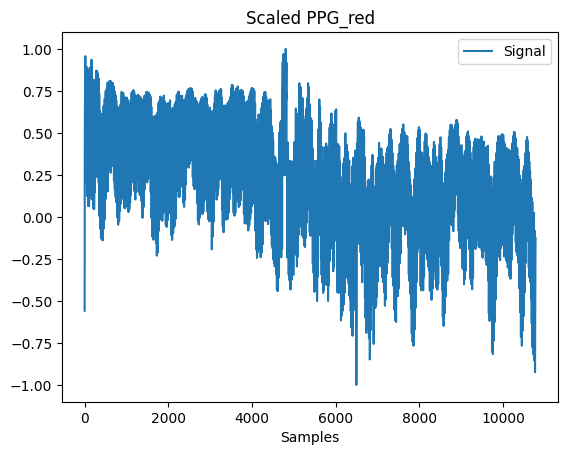

In [27]:
my_data = dataframes['LAURIE_FEATURE_TEST']

from sklearn.preprocessing import RobustScaler

# Columns to process
columns_to_process = ["PPG_red", "PPG_ir", "PPG_green"]

# Define your threshold for deviation from the mean
threshold = 5

ppg_data = []
info = []

for column in columns_to_process:
    
    data = my_data[column]
    # Calculate the mean and standard deviation for each column
    mean = data.mean()
    std_dev = data.std()

    # Filter out outliers
    outliers_mask = (data < mean - threshold * std_dev) | (data > mean + threshold * std_dev)
    outliers = data[outliers_mask]
    filtered_ppg = data[~outliers_mask]

    # Plotting
    plt.figure()
    plt.scatter(my_data['timestamp'][outliers_mask], outliers, color='red', label='Outliers')
    plt.scatter(my_data['timestamp'][~outliers_mask], filtered_ppg, color='blue', label='Filtered Data')
    plt.title(f'Outlier Removal for {column}')
    plt.legend()

    # Reshape data for the scaler
    data_reshaped = filtered_ppg.values.reshape(-1, 1)

    # Initialize the RobustScaler
    robust_scaler = RobustScaler()

    # Fit and transform the data with RobustScaler
    data_robust_scaled = robust_scaler.fit_transform(data_reshaped)

    # Manually scale to [-1, 1] based on the robustly scaled data
    data_scaled_to_range = np.interp(data_robust_scaled, (data_robust_scaled.min(), data_robust_scaled.max()), (-1, 1))

    # Convert back to a pandas series
    ppg_data_scaled = pd.Series(data_scaled_to_range.flatten(), name=column + "_scaled")

    # Append the scaled data to my_data DataFrame or handle it as needed
    my_data[column + "_scaled"] = ppg_data_scaled

    # Plotting scaled data
    nk.signal_plot(ppg_data_scaled)  # This line assumes you want to plot with neurokit2, adjust as necessary
    fig = plt.gcf()
    plt.title(f'Scaled {column}')
    
    ppg_data[column], info[column] = nk.ppg_process(ppg_data_scaled, sampling_rate=SF, method='elgendi', report=None)
    nk.ppg_plot(ppg_data[column], info[column])
    fig = plt.gcf()
    fig.set_size_inches(15, 10, forward=True)
    plt.title(f'Cleaned {column}')
plt.show()